In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm
from multiprocess import Pool


import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [2]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

In [3]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    #print(name)
    culling_factor = od()
    #print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift
    return {"S": result, "L": heat["L"], "D": heat["D"]}

def calc_hc(st, T):

    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    E_qr = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
        E_qr += w * e * e * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

In [7]:
#for D in tqdm([0.0, 0.5, 1.0, 1.5, 1.75, 1.8, 1.87,
#                        1.875, 1.9, 1.92, 1.9375, 1.95, 1.96,
#                        1.962, 1.963, 1.964, 1.965, 1.966, 1.967, 1.968, 1.96875, 1.969,
#                        1.97, 1.99,
#                        1.992]):
D = 0.0
#    L_list = [8, 12, 16, 20, 24, 30, 32, 40, 48, 50, 60, 64, 96]
L_list = [64]
#x = [32]
cool, heat = [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
} for L in L_list], [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
} for L in L_list]
print('D={}'.format(D))

parameters = []
for x in zip(cool, heat):
    try:
        parameters.append(read_tuple_files(x))
    except:
        pass
for i, x in enumerate(parameters):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])
print('L in {}'.format(", ".join([str(x["stitched"]["L"]) for x in parameters]) ))




a = 0.4
b = 2.0

T_crit = {}
for x in parameters:
    st = x["stitched"]
    L = st["L"]
    t, c, _, _ = fminbound(lambda T: - calc_hc(st, T)[1], a, b, maxfun=500, full_output=1, disp=False)
    T_crit[L] = {
        "T_crit": float(t),
        "C_crit": float(-c / (L * L))
    }

print(T_crit)

#    with open("./tmp/T_crit_D{}.txt".format(D), 'w') as fp:
#        for L in T_crit:
#            fp.write('{}\t{}\t{}\n'.format(L, T_crit[L]['T_crit'], T_crit[L]['C_crit']))

D=0.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


L in 64


KeyboardInterrupt: 

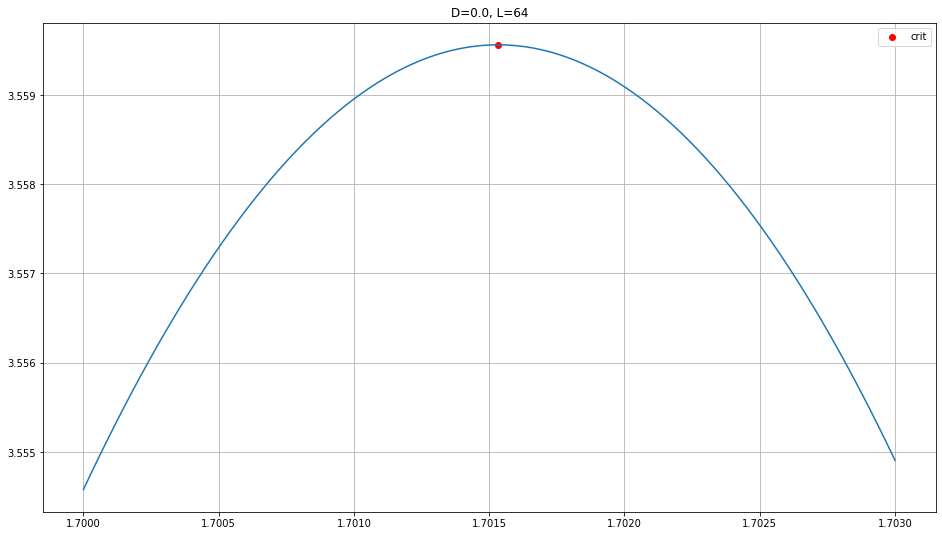

In [24]:
X = [T for T in np.linspace(1.7, 1.703, 100)]

plt.figure(figsize=(16, 9))
plt.scatter(T_crit[L]['T_crit'], T_crit[L]['C_crit'], c='r', label='crit')

plt.plot(X, [calc_hc(st, T)[1] / L**2 for T in X])
plt.title('D={}, L={}'.format(st["D"], st["L"]))
plt.grid()
plt.legend()
plt.show()

In [48]:
for D in tqdm([#0.0, 0.5, 1.0, 1.5, 1.75, 1.8, 1.87,
               #         1.6, 1.7
               #         1.875, 1.9, 1.92, 1.9375, 1.95, 1.96,
               #         1.962, 1.963, 1.964, 1.965, 1.966, 1.967, 1.968, 1.96875, 1.969,
               #         1.97, 1.99,
               #         1.992
]):
#D = 1.992
    L_list = [8, 12, 16, 20, 24, 30, 32, 40, 48, 50, 60, 64, 96]
    #L_list = [32]
    #x = [32]
    cool, heat = [{
        "q": 3,
        "D": D,
        "L": L,
        "R" : 131072,
        "nSteps" : 10,
        "seed" : 0,
        "heat": False
    } for L in L_list], [{
        "q": 3,
        "D": D,
        "L": L,
        "R" : 131072,
        "nSteps" : 10,
        "seed" : 0,
        "heat": True
    } for L in L_list]
    print('D={}'.format(D))

    parameters = []
    for x in zip(cool, heat):
        try:
            parameters.append(read_tuple_files(x))
        except:
            pass
    for i, x in enumerate(tqdm(parameters)):
        parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])
    print('L in {}'.format(", ".join([str(x["stitched"]["L"]) for x in parameters]) ))




    a = 0.8
    b = 1.0

    T_crit = {}
    for x in tqdm(parameters):
        st = x["stitched"]
        L = st["L"]
        t, c, _, _ = fminbound(lambda T: calc_hc(st, T)[3], a, b, maxfun=500, full_output=1, disp=False)
        T_crit[L] = {
            "T_crit": float(t),
            "BC_crit": float(-c / (L * L))
        }

    print(T_crit)

    with open("./tmp/BC_crit_D{}.txt".format(D), 'w') as fp:
        for L in T_crit:
            fp.write('{}\t{}\t{}\n'.format(L, T_crit[L]['T_crit'], T_crit[L]['BC_crit']))

D=1.7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()



L in 8, 12, 16, 20, 24, 32, 48, 64



{8: {'T_crit': 0.8997000102968241, 'BC_crit': 0.001913845218095724}, 12: {'T_crit': 0.8945233494957207, 'BC_crit': 0.001024117261859618}, 16: {'T_crit': 0.8884446877668327, 'BC_crit': 0.00042617770142913854}, 20: {'T_crit': 0.8835937786506569, 'BC_crit': 0.00017874417777519614}, 24: {'T_crit': 0.8808014829277236, 'BC_crit': 0.0001012119981161728}, 32: {'T_crit': 0.8771318677982, 'BC_crit': 3.498610487813337e-05}, 48: {'T_crit': 0.8735246758421892, 'BC_crit': 1.2284986003110051e-05}, 64: {'T_crit': 0.8720304594384745, 'BC_crit': 3.1847576382048514e-06}}



In [3]:
T_crit = {}

In [10]:

D = 0.0
L = 8

cool, heat = [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
}], [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
}]

parameters = []
for x in zip(cool, heat):
    try:
        parameters.append(read_tuple_files(x))
    except:
        pass
for i, x in enumerate(parameters):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])
print('L in {}'.format(", ".join([str(x["stitched"]["L"]) for x in parameters]) ))
T_crit[L] = {}

a = 0.4
b = 2.0
c = 0.7

for x in parameters:
    st = x["stitched"]
    L = st["L"]
    t, bc, _, _ = fminbound(lambda T: - calc_hc(st, T)[3], a, b, maxfun=500, full_output=1, disp=False)
    T_crit[L] = {
        "T_crit": float(t),
        "BC_crit": float(bc)
    }

#for x in tqdm(parameters):
#    st = x["stitched"]
#    L = st["L"]
#    t, bc, _, _ = fminbound(lambda T: calc_hc(st, T)[3], b, c, maxfun=500, full_output=1, disp=False)
#    T_crit[L].update({
#        "T_crit_2": float(t),
#        "BC_crit_2": float(bc)
#    })

print(T_crit)
print('{}\t{}\t{}\n'.format(L, T_crit[L]['T_crit'], T_crit[L]['BC_crit']))
#print('{}\t{}\t{}\n'.format(L, T_crit[L]['T_crit_2'], T_crit[L]['BC_crit_2']))



/var/folders/0v/2xxng9410rl0ldw3shz9xrzw3cbqpn/T/ipykernel_21118/167725292.py:7: RuntimeWarning: divide by zero encountered in log
  sn += np.log(1 - c[E])
/var/folders/0v/2xxng9410rl0ldw3shz9xrzw3cbqpn/T/ipykernel_21118/167725292.py:16: RuntimeWarning: divide by zero encountered in log
  sn += np.log(1 - c[E])


L in 8
{8: {'T_crit': 1.999994105576493, 'BC_crit': 0.5130703383817576}}
8	1.999994105576493	0.5130703383817576



In [47]:
with open("./tmp/BC_crit_D{}.txt".format(D), 'w') as fp:
    for L in T_crit:
        fp.write('{}\t{}\t{}\n'.format(L, T_crit[L]['T_crit'], T_crit[L]['BC_crit']))

In [31]:
from magic_functions import calc_hc_tpl

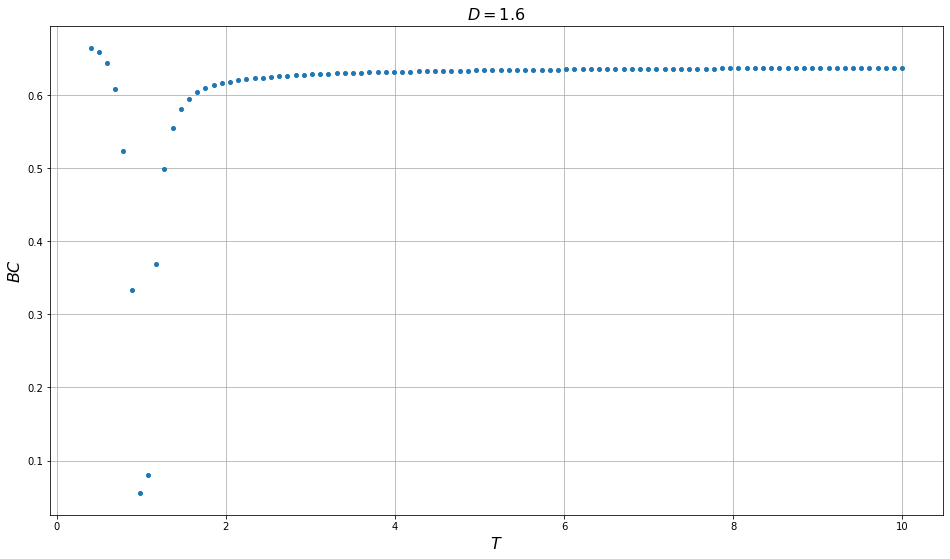

KeyboardInterrupt: 

In [43]:
hc = {}
E = {}
BC = {}

for i, x in enumerate(parameters):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L

    hc[L] = {}
    E[L] = {}
    BC[L] = {}


    frames_list = list(zip(itertools.repeat(st), np.linspace(0.4, 10.0, 100)))

    with Pool(6) as p:
        pool_outputs = list(
                p.map(calc_hc_tpl, tqdm(frames_list, total=len(frames_list)))
        )

    # T, C, average E, BinderCumulant
    for tpl in pool_outputs:
        T, x, y, z = tpl
        hc[L][T], E[L][T], BC[L][T] = x, y, z



    plt.figure(figsize=(16, 9))


    plt.plot([float(T) for T in BC[st["L"]]], [bc for T, bc in BC[st["L"]].items()], 'o', markerSize = 4)
    plt.grid()
    plt.title("$D={}$".format(st["D"]), fontsize=16)
    plt.ylabel('$BC$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.show()
    #plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))


In [4]:
T_crit = {}
C_crit = {}
for D in tqdm([0.0, 0.5, 1.0, 1.5, 1.75, 1.8, 1.87,
                        1.875, 1.9, 1.92, 1.9375, 1.95, 1.96,
                        1.962, 1.963, 1.964, 1.965, 1.966, 1.967, 1.968, 1.96875, 1.969,
                        1.97, 1.99,
                        1.992]):
#D = 0.0
    T_crit[D] = {}
    C_crit[D] = {}
    with open("./tmp/T_crit_D{}.txt".format(D), 'r') as fp:
        for line in fp:
            L, T, C = line.split()
            T_crit[D][int(L)] = float(T)
            C_crit[D][int(L)] = float(C)

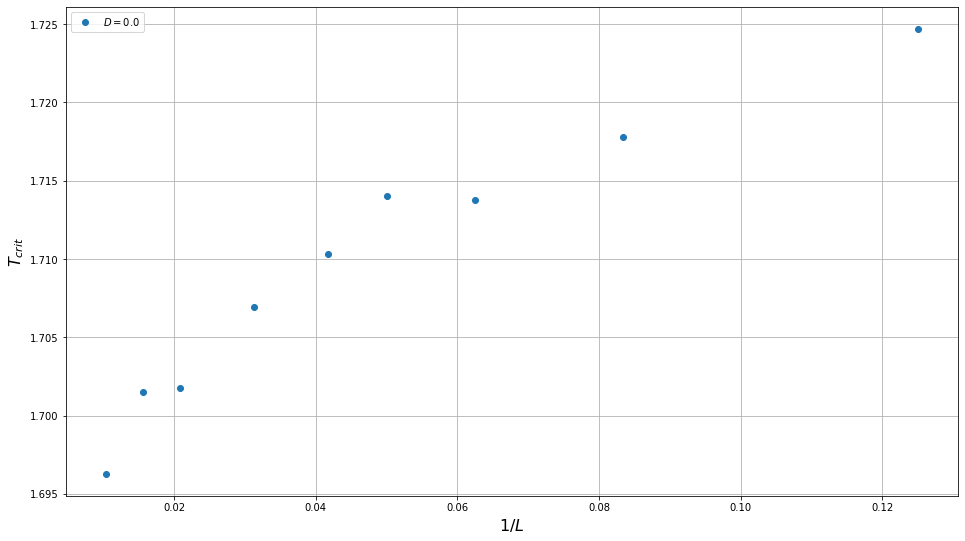

In [5]:
plt.figure(figsize=(16, 9))

D = 0.0
plt.plot([1/L for L in T_crit[D]], [T for L, T in T_crit[D].items()], 'o', label="$D={}$".format(D))
#plt.yscale('log')
#plt.xscale('log')
#plt.title("$D={}$".format(D), fontsize=16)
plt.xlabel(r'$1/L$', fontsize=16)
plt.ylabel(r"$T_{crit}$", fontsize=16)
plt.legend()
plt.grid(True, which="both")
plt.show()

(array([0.015625  , 0.00694444, 0.00390625, 0.0025    , 0.00173611,
        0.00097656, 0.00043403, 0.00024414, 0.00010851]),
 array([1.4088887 , 1.41137802, 1.41297188, 1.41008664, 1.41097004,
        1.40549362, 1.40495908, 1.40321056, 1.40282392]))

slope: 	-0.004890198743337357 +/-
	0.0005126887331833568
shift: 	0.4729281908706351 +/-
	0.0017292439457423441


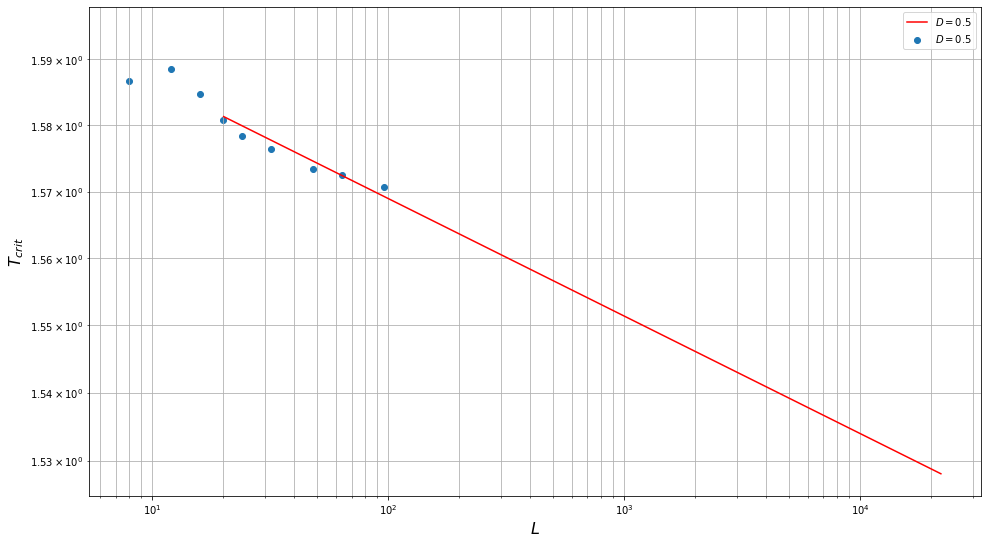

In [29]:
D = 0.5
x = np.array([L for L in T_crit[D].keys()])
y = np.array([T for L, T in T_crit[D].items()])

l = 0
fit = np.polyfit(np.log(x[l:]), np.log(y[l:]), 1, full=False)

plt.figure(figsize=(16, 9))

plt.scatter(x, y, label="$D={}$".format(D))

sample = np.linspace(3, 10, 20)
plt.plot(np.exp(sample), np.exp(fit[0] * sample + fit[1]), 'r', label="$D={}$".format(D))

plt.xlabel(r'$L$', fontsize=16)
plt.ylabel(r"$T_{crit}$", fontsize=16)
plt.yscale("log")
plt.xscale("log")
plt.grid(True, which="both")
plt.legend()
#plt.savefig("./finite_size_D{}.png".format(D))

p, V = np.polyfit(np.log(x[l:]), np.log(y[l:]), 1, cov=True)

print("slope: \t{} +/-\n\t{}".format(p[0], np.sqrt(V[0][0])))
print("shift: \t{} +/-\n\t{}".format(p[1], np.sqrt(V[1][1])))
